In [1]:
import sys
sys.path.append("C:/Users/dsill/Desktop/stock-prediction")
from davidplayground.datasets import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
sns.set()

In [2]:
ltc = CoinDataset(name='LTC')
data = ltc.get(start="2020-09-22", end="2021-09-22", granularity=3600)

In [3]:
df = data.copy()
df.columns = [c.capitalize() for c in df.columns]
df = df.set_index('Time')
df.head()

,Close,High,Low,Open,Volume
Time,,,,,
2020-09-21 20:00:00,43.48,43.71,42.77,43.15,6734.468239
2020-09-21 21:00:00,43.22,43.48,43.08,43.48,3680.416091
2020-09-21 22:00:00,43.45,43.45,43.19,43.28,3107.865146
2020-09-21 23:00:00,43.48,43.65,43.42,43.45,2669.144195
2020-09-22 00:00:00,43.61,43.78,43.52,43.53,3995.041814


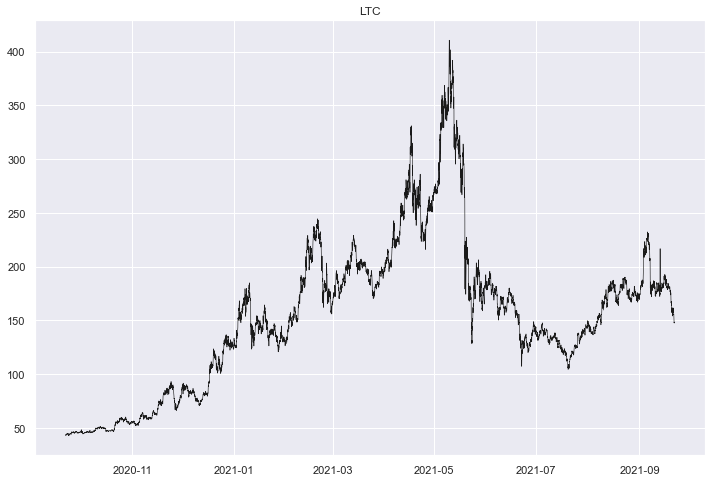

In [4]:
fig, ax = plt.subplots()
ax.plot(df.index, df['Close'], lw=0.6, c='k')
ax.set_title("LTC")
fig.set_size_inches(12,8)
plt.show()

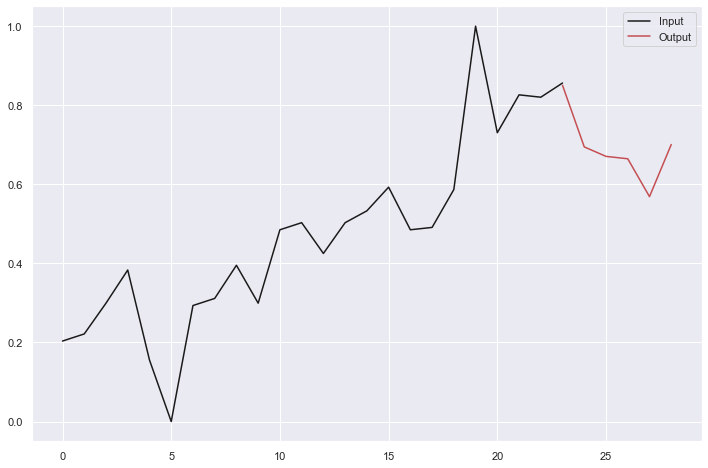

In [5]:
XY = [(df.iloc[i:i+24, 0], df.iloc[i+24:i+30, 0]) for i in range(len(df) - 30)]
X = [np.array(xy[0]) for xy in XY]
y = [np.array(xy[1]) for xy in XY]
for i in range(len(X)):
    scl = MinMaxScaler().fit(X[i].reshape(-1,1))
    X[i] = scl.transform(X[i].reshape(-1,1)).flatten()
    y[i] = scl.transform(y[i].reshape(-1,1)).flatten()
fig, ax = plt.subplots()
itest = 2
ax.plot(range(len(X[itest])), X[itest], c='k', label='Input')
ax.plot(range(len(X[itest])-1, len(X[itest])+len(y[itest])-1), y[itest], c='r', label='Output')
ax.legend()
fig.set_size_inches(12,8)
plt.show()

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 12, 32)       128         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 6, 64)        6208        conv1d_9[0][0]                   
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 384)          0           conv1d_10[0][0]                  
____________________________________________________________________________________________

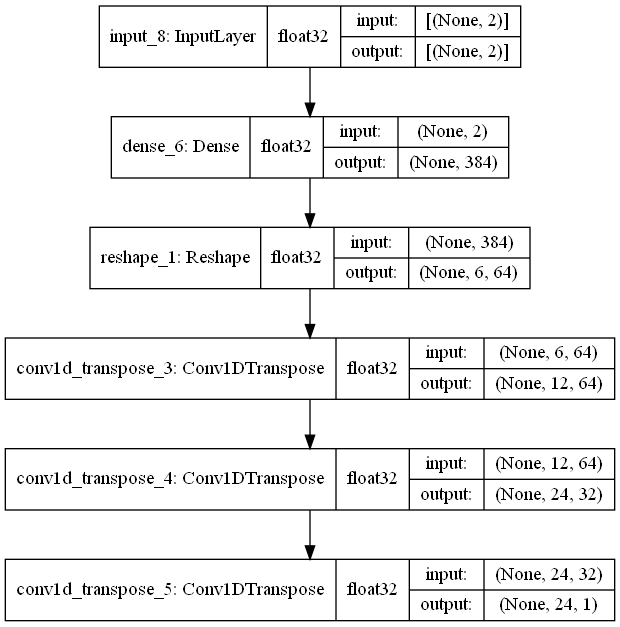

In [12]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2
encoder_inputs = keras.Input(shape=(24,1,))
x = keras.layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = keras.layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation='relu')(x)
z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True, show_dtype=True)

latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(6*64, activation='relu')(latent_inputs)
x = keras.layers.Reshape((6,64))(x)
x = keras.layers.Conv1DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = keras.layers.Conv1DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True, show_dtype=True)